In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import StandardScaler
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in the entire dataset
master = pd.read_excel('..\Data Cleanup\cleaned_data.xlsx', sheet_name = 'master')

master = master[(master['EffMeas'] == 'LR')]

In [3]:
data = master[(master['AppMethod'] == 'fumigation') & (master['HVAC'] == 0) & (master['IndoorCarpet'] == 0) &
                                 (master['Soil'] == 0) & (master['Roofing'] == 0) & (master['UndergroundCarpet'] == 0) & 
                                 (master['IndoorMisc'] == 1)]

y = data.Eff.dropna().tolist()
x = np.arange(len(y))
size = len(y)

In [10]:
print(size)

123


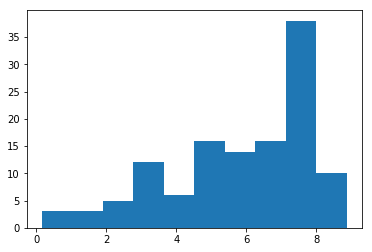

In [4]:
plt.hist(y)
plt.show()

In [5]:
y_df = pd.DataFrame(data.Eff.tolist(), columns=['Data'])
y_df.describe()

,Data
count,123.000000
mean,5.932040
std,2.079641
min,0.170000
25%,4.650000
50%,6.570000
75%,7.575000
max,8.860000


In [6]:
sc=StandardScaler() 
yy = np.array(y).reshape(-1,1)
sc.fit(yy)
y_std =sc.transform(yy)
y_std = y_std.flatten()
y_std
del yy

In [7]:
dist_names = ['beta',
              'truncexpon',
              'gamma',
              'lognorm',
              'truncnorm',
              'pearson3',
              'triang',
              'uniform',
              'weibull_min', 
              'weibull_max']

In [8]:
# Set up empty lists to store results
chi_square = []
p_values = []

# Set up 50 bins for chi-square test
# Observed data will be approximately evenly distrubuted aross all bins
percentile_bins = np.linspace(0,100,51)
percentile_cutoffs = np.percentile(y_std, percentile_bins)
observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
cum_observed_frequency = np.cumsum(observed_frequency)

# Loop through candidate distributions

for distribution in dist_names:
    # Set up distribution and get fitted distribution parameters
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std)
    
    # Obtain the KS test P statistic, round it to 5 decimal places
    p = scipy.stats.kstest(y_std, distribution, args=param)[1]
    p = np.around(p, 5)
    p_values.append(p)    
    
    # Get expected counts in percentile bins
    # This is based on a 'cumulative distrubution function' (cdf)
    cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                          scale=param[-1])
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)
    
    # calculate chi-squared
    expected_frequency = np.array(expected_frequency) * size
    cum_expected_frequency = np.cumsum(expected_frequency)
    ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
    chi_square.append(ss)
        
# Collate results and sort by goodness of fit (best at top)

results = pd.DataFrame()
results['Distribution'] = dist_names
results['chi_square'] = chi_square
results['p_value'] = p_values
results.sort_values(['chi_square'], inplace=True)
    
# Report results

print ('\nDistributions sorted by goodness of fit:')
print ('----------------------------------------')
print (results)


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
6       triang     13.366420  0.09985
0         beta     17.031885  0.02470
9  weibull_max     23.875524  0.44699
3      lognorm     56.166976  0.01021
2        gamma     62.847341  0.00646
7      uniform    903.257663  0.00000
4    truncnorm   1268.856185  0.00000
1   truncexpon   1792.005133  0.00000
8  weibull_min   5259.813368  0.00000
5     pearson3  11886.856598  0.00000


C:\Users\PERAZA\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:5823: RuntimeWarning: divide by zero encountered in log
  self._logdelta = np.log(self._delta)
C:\Users\PERAZA\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:5823: RuntimeWarning: invalid value encountered in log
  self._logdelta = np.log(self._delta)


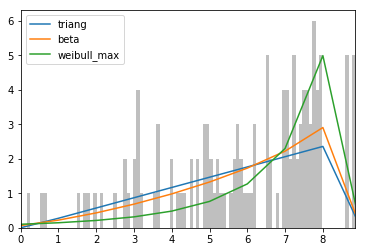


Distribution parameters:
------------------------

Distribution: triang
Parameters: (0.9999999313409134, 0.07275904671465822, 8.787242366709929)

Distribution: beta
Parameters: (2.4153622100812626, 0.8750028533795264, -0.7238049891818777, 9.583804989181878)

Distribution: weibull_max
Parameters: (0.7118770354995805, 8.860000000000001, 1.2768909888722604)


In [9]:
# Divide the observed data into 100 bins for plotting (this can be changed)
number_of_bins = 100
bin_cutoffs = np.linspace(np.percentile(y,0), np.percentile(y,99),number_of_bins)

# Create the plot
h = plt.hist(y, bins = bin_cutoffs, color='0.75')

# Get the top three distributions from the previous phase
number_distributions_to_plot = 3
dist_names = results['Distribution'].iloc[0:number_distributions_to_plot]

# Create an empty list to stroe fitted distribution parameters
parameters = []

# Loop through the distributions to get line fit and paraemters

for dist_name in dist_names:
    # Set up distribution and store distribution paraemters
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    parameters.append(param)
    
    # Get line for each distribution (and scale to match observed data)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
    scale_pdf = np.trapz (h[0], h[1][:-1]) / np.trapz (pdf_fitted, x)
    pdf_fitted *= scale_pdf
    
    # Add the line to the plot
    plt.plot(pdf_fitted, label=dist_name)
    
    # Set the plot x axis to contain 99% of the data
    # This can be removed, but sometimes outlier data makes the plot less clear
    plt.xlim(0,np.percentile(y,99))

# Add legend and display plot

plt.legend()
plt.show()

# Store distribution paraemters in a dataframe (this could also be saved)
dist_parameters = pd.DataFrame()
dist_parameters['Distribution'] = (
        results['Distribution'].iloc[0:number_distributions_to_plot])
dist_parameters['Distribution parameters'] = parameters

# Print parameter results
print ('\nDistribution parameters:')
print ('------------------------')

for index, row in dist_parameters.iterrows():
    print ('\nDistribution:', row[0])
    print ('Parameters:', row[1] )